In [1]:

import jax.numpy as jnp

import sys
sys.path.insert(1,'..')

import utils
import loader
import tqdm
%load_ext autoreload
%autoreload 2
import imp
imp.reload(loader)
import setup
import scipy.stats as sts
from matplotlib import pyplot as plt

import numpy as np
from sklearn.linear_model import LogisticRegression,LinearRegression, Ridge,Lasso

logreg = LogisticRegression(penalty='l2')
linreg = LinearRegression()
linridge  = Ridge(alpha=2)
from sklearn.metrics import r2_score

/Users/jbarbosa/anaconda3/envs/netrep/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-07-22 19:14:10,826	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
/Users/jbarbosa/anaconda3/envs/netrep/lib/python3.11/site-packages/ibllib/atlas/__init__.py:205: DeprecationWarning: ibllib.atlas is deprecated. Please install iblatlas using "pip install iblatlas" and use this module instead
  warnings.warn('ibllib.atlas is deprecated. Please install iblatlas using "pip install iblatlas" and use '


In [34]:
#load data 
with(open("100_avg_folds_response_aligned.pkl","rb")) as f:
    import pickle
    params,_ys,train_data_folds,test_data_folds = pickle.load(f)

# # load data 
# with(open("25_avg_folds_stim_aligned.pkl","rb")) as f:
#     import pickle
#     params,_ys,train_data_folds,test_data_folds = pickle.load(f)
    
    

In [35]:
n_folds = 25
w = 10

n_shuffles = 25



linridge  = Ridge(alpha=0.05) # 
all_scores = []
all_cs = []
for fold in tqdm.trange(n_folds):
    
    train_fold, test_fold = train_data_folds[fold],test_data_folds[fold]
    ys_time_train,cs_time_train = zip(*train_fold)
    ys_time_test,cs_time_test = zip(*test_fold)

    # fitler out sessions with too few neurons or trials
    min_neurons = 100
    min_trials = 20

    valid = [i for i in range(len(ys_time_train)) if np.array(_ys[i]).shape[-1] >= min_neurons and np.array(_ys[i]).shape[1] >= min_trials]
    ys_time_train = [ys_time_train[i] for i in valid]
    ys_time_test = [ys_time_test[i] for i in valid]

    cs_train = [cs_time_train[i] for i in valid]
    cs_test = [cs_time_test[i] for i in valid]
    

    S = len(ys_time_train)

    scores_stim = np.zeros((len(ys_time_train[0])-w,S))
    scores_resp = np.zeros((len(ys_time_train[0])-w,S))


        
    for t in range(len(ys_time_train[0])-w):

        all_sessions_score = []
        for session in range(S):
            ys_sess_train = np.mean(ys_time_train[session][t:t+w,:],0)
            ys_sess_test = np.mean(ys_time_test[session][t:t+w,:],0)

            l_resp=linridge.fit(ys_sess_train, cs_train[session][t])
            scores_resp[t,session] = r2_score(cs_test[session][t],l_resp.predict(ys_sess_test))

            l_stim=linridge.fit(ys_sess_train, range(9))
            scores_stim[t,session] = r2_score(range(9),l_stim.predict(ys_sess_test))


    all_scores.append([scores_stim,scores_resp])
    all_cs.append(cs_test)
    
all_scores = np.array(all_scores)

100%|██████████| 25/25 [02:35<00:00,  6.23s/it]


# shuffles

In [4]:
# shuffles = np.zeros((n_shuffles,len(ys_time_train[0])-w,S))
# stims = np.arange(9)

# for t in tqdm.trange(58,len(ys_time_train[0])-w):

#     all_sessions_score = []
#     for session in range(S):
#         ys_sess_train = np.mean(ys_time_train[session][t:t+w,:],0)
#         ys_sess_test = np.mean(ys_time_test[session][t:t+w,:],0)

#        # shuffles_labels = cs_train[session][t].copy()
#         shuffles_labels = np.arange(9)
#         for ss in range(n_shuffles):
#             np.random.shuffle(shuffles_labels)
#             # l_resp=linridge.fit(ys_sess_train, shuffles_labels)
#             # shuffles[ss,t,session] = r2_score(cs_test[session][t],l_resp.predict(ys_sess_test))
#             l_resp=linridge.fit(ys_sess_train, shuffles_labels)
#             shuffles[ss,t,session] = r2_score(np.arange(9),l_resp.predict(ys_sess_test))

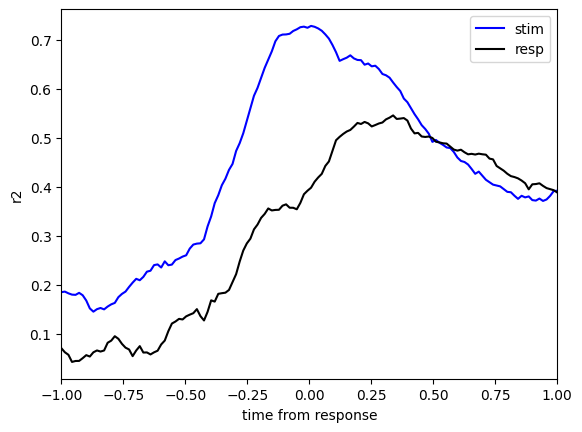

In [36]:
from matplotlib import pyplot as plt
x_time = np.linspace(-1,1,len(all_scores[0,0]))
plt.plot(x_time,np.nanmean(np.mean(all_scores[:,0],-1),0),color="blue",label="stim")
plt.plot(x_time,np.nanmean(np.mean(all_scores[:,1],-1),0),color="k",label="resp")
#plt.plot(x_time,[np.percentile(np.mean(shuffles,-1)[:,t],[2.5,97.5]) for t in range(140)],"gray",label="shuffle")
plt.ylabel("r2")
plt.xlabel("time from response")
plt.xlim(-1,1)
plt.legend()

In [39]:
all_corrs = np.zeros((10,140))
for fold in range(10):
    for t in range(140):
        dist_neural = np.zeros((S,S))
        dist_cc = np.zeros((S,S))
        for i in range(S):
            for j in range(S):
                dist_neural[i,j] = np.abs(all_scores[fold,1,t,i]-all_scores[fold,1,t,j])
                dist_cc[i,j] = np.mean(np.abs(all_cs[0][i][t]- all_cs[0][j][t]))

        d_n = dist_neural[np.triu_indices(S,1)].reshape(-1)
        d_c = dist_cc[np.triu_indices(S,1)].reshape(-1)
        all_corrs[fold,t]=sts.pearsonr(d_n,d_c)[0]


In [38]:
all_corrs_stim = all_corrs.copy()

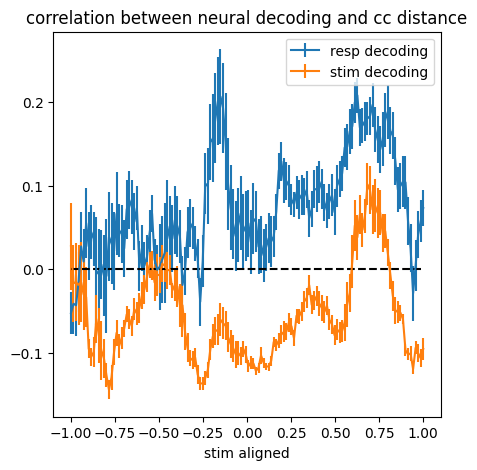

In [40]:
plt.figure(figsize=(5,5))
plt.errorbar(x_time,np.median(all_corrs,0),sts.sem(all_corrs,0),label="resp decoding")
plt.errorbar(x_time,np.mean(all_corrs_stim,0),sts.sem(all_corrs_stim,0),label="stim decoding")

plt.plot([-1,1],[0,0],"k--")
#plt.xlim(0,1)
plt.xlabel("stim aligned")
plt.title("correlation between neural decoding and cc distance")
plt.legend()

In [10]:
k

NameError: name 'k' is not defined

## cross decoding

In [ ]:
n_folds = 10
w = 10

n_shuffles = 25


all_scores = []
all_coefs = []
linridge  = Ridge(alpha=0.05) # 0.O2
logreg = LogisticRegression(penalty='l2')

for fold in range(1):

    all_coefs_f = []
    
    train_fold, test_fold = train_data_folds[fold],test_data_folds[fold]
    ys_time_train,cs_time_train = zip(*train_fold)
    ys_time_test,cs_time_test = zip(*test_fold)

    # fitler out sessions with too few neurons or trials
    min_neurons = 100
    min_trials = 20

    valid = [i for i in range(len(ys_time_train)) if np.array(_ys[i]).shape[-1] >= min_neurons and np.array(_ys[i]).shape[1] >= min_trials]
    ys_time_train = [ys_time_train[i] for i in valid]
    ys_time_test = [ys_time_test[i] for i in valid]

    cs_train = [cs_time_train[i] for i in valid]
    cs_test = [cs_time_test[i] for i in valid]

    S = len(ys_time_train)

    scores_stim = np.zeros((len(ys_time_train[0])-w,len(ys_time_train[0])-w,S))
    scores_resp = np.zeros((len(ys_time_train[0])-w,len(ys_time_train[0])-w,S))


    for t in tqdm.trange(len(ys_time_train[0])-w):
        for test in range(len(ys_time_train[0])-w):

            all_sessions_score = []
            all_sessions_coefs  = []
            for session in range(S):
                ys_sess_train = np.mean(ys_time_train[session][t:t+w,:],0)
                ys_sess_test = np.mean(ys_time_test[session][test:test+w,:],0)

                l_resp=linridge.fit(ys_sess_train, cs_train[session][t])
                scores_resp[t,test,session] = r2_score(cs_test[session][test],l_resp.predict(ys_sess_test))

                l_stim=linridge.fit(ys_sess_train, range(9))
                scores_stim[t,test,session] = r2_score(range(9),l_stim.predict(ys_sess_test))
            #     all_sessions_coefs.append([l_stim.coef_,l_resp.coef_])
            # all_coefs_f.append(all_sessions_coefs)


    all_scores.append([scores_stim,scores_resp])
    # all_coefs.append(all_coefs_f)
    
all_scores = np.array(all_scores)


In [ ]:
plt.subplot(2,2,1)
plt.imshow(np.mean(all_scores[0][0],-1),vmin=0,vmax=1)
plt.colorbar()
plt.title("stim stim algined")

plt.subplot(2,2,2)
plt.imshow(np.mean(all_scores[0][1],-1),vmin=0,vmax=1)
plt.colorbar()
plt.title("response, stim algined")